In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, mean_squared_error
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
import time
import torch.utils.data as torch_data
from keras.datasets import mnist

Using TensorFlow backend.


## 1. Reconstruction of MNIST with MLP-based autoencoder

In [0]:


(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)

#Get only first 1000 pictures for test
x_test=x_test[:1000]
y_test=y_test[:1000]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print("[mnist] x_train.shape={}, y_train.shape={}".format(x_train.shape, y_train.shape))
print("[mnist] x_test.shape={}, y_test.shape={}".format(x_test.shape, y_test.shape))

[mnist] x_train.shape=(60000, 784), y_train.shape=(60000,)
[mnist] x_test.shape=(1000, 784), y_test.shape=(1000,)


Text(0, 0.5, '$Original$')

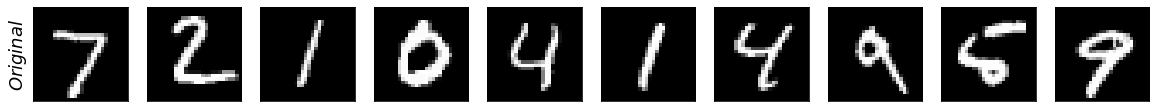

In [0]:
fig, ax = plt.subplots(ncols=10, nrows=1, figsize=(20, 2.5))

for i in range(10):
  rec = x_test[i,:]
  ax[i].imshow(rec.reshape(28,28),cmap='gray')
  ax[i].get_xaxis().set_ticks([])
  ax[i].get_yaxis().set_ticks([])
ax[0].set_ylabel(f"$Original$",fontsize=18)
      

### 1.1 MLP-1

In [0]:
REC1=[]
MSE1=[]

0% of dropout

In [0]:
class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x=x.reshape(x.shape[0],-1)
        return self.decoder(self.encoder(x))

encoder = lambda hid: nn.Sequential(
                        torch.nn.Linear(784,1024, bias=True),
                        torch.nn.BatchNorm1d(1024),
                        torch.nn.ReLU(),
                       

                        torch.nn.Linear(1024, hid,bias=True),
                        ) 

decoder =  lambda hid: nn.Sequential( 
                        torch.nn.Linear(hid, 1024, bias=True),
                        torch.nn.BatchNorm1d(1024),
                        torch.nn.ReLU(),
                    
                       

                        torch.nn.Linear(1024, 784, bias=True),
                        torch.nn.BatchNorm1d(784),
                        torch.nn.ReLU(),
                        ) 
def train(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, save_dir=None):
    start = time.time()
    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        for X  in train_loader:
            # Perform one step of minibatch stochastic gradient descent 
          
          X=X.to(device)
        
          out=net(X)
          loss=criterion(out,X)

          optimizer.zero_grad()

          loss.backward()
          optimizer.step()
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
    
        net.eval()
        for X in val_loader:
            # Compute the validation loss
             
            X=X.to(device)
            out=net(X)
            val_loss=criterion(out,X)
         
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, loss.item(), val_loss.item()))
    end= time.time()
    print("construction completed in "+str(end-start)+'s')


In [0]:
device = 'cuda:0'
train_loader = torch.utils.data.DataLoader(x_train, batch_size=500,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(x_test, batch_size=500,
                                         shuffle=False, num_workers=2)

net = AE(encoder(500), decoder(500))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
epochs = 1000
train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

Epoch 50/1000 || Loss:  Train 6181.7051 | Validation 5889.9229
Epoch 100/1000 || Loss:  Train 5381.7505 | Validation 5111.3325
Epoch 150/1000 || Loss:  Train 4835.4893 | Validation 4414.9585
Epoch 200/1000 || Loss:  Train 4127.6416 | Validation 3764.2039
Epoch 250/1000 || Loss:  Train 3325.4695 | Validation 3201.6174
Epoch 300/1000 || Loss:  Train 2763.6545 | Validation 2658.7034
Epoch 350/1000 || Loss:  Train 2358.5718 | Validation 2199.6245
Epoch 400/1000 || Loss:  Train 1883.6998 | Validation 1780.1038
Epoch 450/1000 || Loss:  Train 1477.3596 | Validation 1449.3717
Epoch 500/1000 || Loss:  Train 1187.9561 | Validation 1111.8873
Epoch 550/1000 || Loss:  Train 863.3583 | Validation 861.1898
Epoch 600/1000 || Loss:  Train 667.1124 | Validation 635.9154
Epoch 650/1000 || Loss:  Train 492.4628 | Validation 457.5406
Epoch 700/1000 || Loss:  Train 336.1102 | Validation 302.3915
Epoch 750/1000 || Loss:  Train 215.9303 | Validation 198.4619
Epoch 800/1000 || Loss:  Train 120.9401 | Validatio

In [0]:

net.eval()
test_loader = torch.utils.data.DataLoader(x_test, batch_size=1,
                                         shuffle=False, num_workers=2)
batch_count=0
reconstruction_time=[]
running_loss_val=0
for X in test_loader:
    X=X.to(device)
    encoded=net.encoder(X)
    start=time.time()
    reconstructions_batch=net.decoder(encoded)
    end=time.time()
    reconstruction_time.append(end-start)
    if batch_count == 0:
      rec = reconstructions_batch
    else:
      rec = torch.cat((rec, reconstructions_batch), dim=0)
    batch_count += 1
    loss_val = criterion(reconstructions_batch, X)
    running_loss_val += loss_val.item()
MSE1.append(running_loss_val/batch_count)
rec = rec.cpu().detach().numpy()
REC1.append(rec)
mean=np.mean(np.array(reconstruction_time))
print("decode one sample in "+str(mean)+'s')



decode one sample in 0.00029295086860656736s


25% of dropout


In [0]:
class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x=x.reshape(x.shape[0],-1)
        return self.decoder(self.encoder(x))

encoder = lambda hid: nn.Sequential(
                        torch.nn.Linear(784,1024, bias=True),
                        torch.nn.BatchNorm1d(1024),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                       

                        torch.nn.Linear(1024, hid,bias=True),
                        ) 

decoder =  lambda hid: nn.Sequential( 
                        torch.nn.Linear(hid, 1024, bias=True),
                        torch.nn.BatchNorm1d(1024),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                       

                        torch.nn.Linear(1024, 784, bias=True),
                        torch.nn.BatchNorm1d(784),
                        torch.nn.ReLU(),
                        ) 


In [0]:
device = 'cuda:0'
train_loader = torch.utils.data.DataLoader(x_train, batch_size=500,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(x_test, batch_size=500,
                                         shuffle=False, num_workers=2)

net = AE(encoder(500), decoder(500))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
epochs = 1000
train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

Epoch 50/1000 || Loss:  Train 6386.2378 | Validation 5940.6860
Epoch 100/1000 || Loss:  Train 5637.2373 | Validation 5191.4990
Epoch 150/1000 || Loss:  Train 4570.2822 | Validation 4506.9619
Epoch 200/1000 || Loss:  Train 4220.6929 | Validation 3880.1631
Epoch 250/1000 || Loss:  Train 3490.6565 | Validation 3323.6279
Epoch 300/1000 || Loss:  Train 2929.2144 | Validation 2813.0935
Epoch 350/1000 || Loss:  Train 2465.1714 | Validation 2354.4116
Epoch 400/1000 || Loss:  Train 2157.7471 | Validation 1980.7728
Epoch 450/1000 || Loss:  Train 1749.6036 | Validation 1626.8618
Epoch 500/1000 || Loss:  Train 1452.5343 | Validation 1300.1718
Epoch 550/1000 || Loss:  Train 1171.3496 | Validation 1031.4392
Epoch 600/1000 || Loss:  Train 994.8040 | Validation 815.6650
Epoch 650/1000 || Loss:  Train 786.9169 | Validation 626.8427
Epoch 700/1000 || Loss:  Train 629.6719 | Validation 477.3458
Epoch 750/1000 || Loss:  Train 539.7899 | Validation 356.5628
Epoch 800/1000 || Loss:  Train 460.7652 | Validat

In [0]:
net.eval()
test_loader = torch.utils.data.DataLoader(x_test, batch_size=1,
                                         shuffle=False, num_workers=2)
batch_count=0
reconstruction_time=[]
running_loss_val=0
for X in test_loader:
    X=X.to(device)
    encoded=net.encoder(X)
    start=time.time()
    reconstructions_batch=net.decoder(encoded)
    end=time.time()
    reconstruction_time.append(end-start)
    if batch_count == 0:
      rec = reconstructions_batch
    else:
      rec = torch.cat((rec, reconstructions_batch), dim=0)
    batch_count += 1
    loss_val = criterion(reconstructions_batch, X)
    running_loss_val += loss_val.item()
MSE1.append(running_loss_val/batch_count)
rec = rec.cpu().detach().numpy()
REC1.append(rec)
mean=np.mean(np.array(reconstruction_time))
print("decode one sample in "+str(mean)+'s')

decode one sample in 0.00031030774116516115s


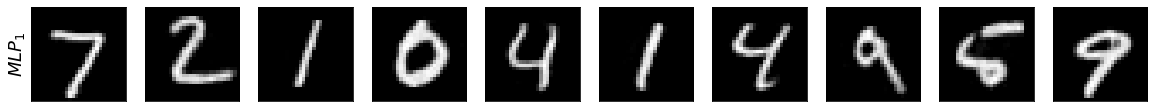

In [0]:

fig, ax = plt.subplots(ncols=10, nrows=1, figsize=(20, 2.5))
for X_test in test_loader:
  for i in range(10):
      ax[i].imshow(rec[i].reshape(28,28),cmap='gray')
      ax[i].get_xaxis().set_ticks([])
      ax[i].get_yaxis().set_ticks([])
  ax[0].set_ylabel(f"$MLP_1$",fontsize=18)
  break

50% of dropout

In [0]:
class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x=x.reshape(x.shape[0],-1)
        return self.decoder(self.encoder(x))

encoder = lambda hid: nn.Sequential(
                        torch.nn.Linear(784,1024, bias=True),
                        torch.nn.BatchNorm1d(1024),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.50),
                       

                        torch.nn.Linear(1024, hid,bias=True),
                        ) 

decoder =  lambda hid: nn.Sequential( 
                        torch.nn.Linear(hid, 1024, bias=True),
                        torch.nn.BatchNorm1d(1024),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.50),
                       

                        torch.nn.Linear(1024, 784, bias=True),
                        torch.nn.BatchNorm1d(784),
                        torch.nn.ReLU(),
                        ) 

In [0]:
device = 'cuda:0'
train_loader = torch.utils.data.DataLoader(x_train, batch_size=500,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(x_test, batch_size=500,
                                         shuffle=False, num_workers=2)
net = AE(encoder(500), decoder(500))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
epochs = 1000
train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

Epoch 50/1000 || Loss:  Train 6199.0454 | Validation 5984.2290
Epoch 100/1000 || Loss:  Train 5360.6367 | Validation 5267.1484
Epoch 150/1000 || Loss:  Train 4919.5723 | Validation 4620.9849
Epoch 200/1000 || Loss:  Train 4266.0327 | Validation 4002.5068
Epoch 250/1000 || Loss:  Train 3776.7117 | Validation 3465.3850
Epoch 300/1000 || Loss:  Train 3219.2371 | Validation 2977.3862
Epoch 350/1000 || Loss:  Train 2791.4944 | Validation 2532.9629
Epoch 400/1000 || Loss:  Train 2343.4407 | Validation 2157.3557
Epoch 450/1000 || Loss:  Train 2087.3027 | Validation 1820.3723
Epoch 500/1000 || Loss:  Train 1712.2919 | Validation 1498.8153
Epoch 550/1000 || Loss:  Train 1401.3516 | Validation 1239.2168
Epoch 600/1000 || Loss:  Train 1305.1444 | Validation 1021.1694
Epoch 650/1000 || Loss:  Train 1117.7649 | Validation 829.3254
Epoch 700/1000 || Loss:  Train 936.9033 | Validation 691.4793
Epoch 750/1000 || Loss:  Train 851.1203 | Validation 570.6173
Epoch 800/1000 || Loss:  Train 790.6152 | Vali

In [0]:
net.eval()
test_loader = torch.utils.data.DataLoader(x_test, batch_size=1,
                                         shuffle=False, num_workers=2)
batch_count=0
reconstruction_time=[]
running_loss_val=0
for X in test_loader:
    X=X.to(device)
    encoded=net.encoder(X)
    start=time.time()
    reconstructions_batch=net.decoder(encoded)
    end=time.time()
    reconstruction_time.append(end-start)
    if batch_count == 0:
      rec = reconstructions_batch
    else:
      rec = torch.cat((rec, reconstructions_batch), dim=0)
    batch_count += 1
    loss_val = criterion(reconstructions_batch, X)
    running_loss_val += loss_val.item()
MSE1.append(running_loss_val/batch_count)
rec = rec.cpu().detach().numpy()
REC1.append(rec)
mean=np.mean(np.array(reconstruction_time))
print("decode one sample in "+str(mean)+'s')

decode one sample in 0.00032176971435546873s


75% of dropout

In [0]:
class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x=x.reshape(x.shape[0],-1)
        return self.decoder(self.encoder(x))

encoder = lambda hid: nn.Sequential(
                        torch.nn.Linear(784,1024, bias=True),
                        torch.nn.BatchNorm1d(1024),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.75),
                       

                        torch.nn.Linear(1024, hid,bias=True),
                        ) 

decoder =  lambda hid: nn.Sequential( 
                        torch.nn.Linear(hid, 1024, bias=True),
                        torch.nn.BatchNorm1d(1024),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.75),
                       

                        torch.nn.Linear(1024, 784, bias=True),
                        torch.nn.BatchNorm1d(784),
                        torch.nn.ReLU(),
                        ) 

In [0]:
device = 'cuda:0'
train_loader = torch.utils.data.DataLoader(x_train, batch_size=500,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(x_test, batch_size=500,
                                         shuffle=False, num_workers=2)
net = AE(encoder(500), decoder(500))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
epochs = 1000
train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

Epoch 50/1000 || Loss:  Train 6584.5103 | Validation 6054.4468
Epoch 100/1000 || Loss:  Train 5836.1870 | Validation 5393.3530
Epoch 150/1000 || Loss:  Train 5062.7217 | Validation 4783.4961
Epoch 200/1000 || Loss:  Train 4436.6216 | Validation 4222.3726
Epoch 250/1000 || Loss:  Train 3940.2163 | Validation 3716.4629
Epoch 300/1000 || Loss:  Train 3370.6204 | Validation 3256.4648
Epoch 350/1000 || Loss:  Train 3014.5605 | Validation 2846.9092
Epoch 400/1000 || Loss:  Train 2666.0410 | Validation 2474.7522
Epoch 450/1000 || Loss:  Train 2379.7703 | Validation 2154.9846
Epoch 500/1000 || Loss:  Train 2121.1050 | Validation 1866.7046
Epoch 550/1000 || Loss:  Train 1931.6798 | Validation 1611.8929
Epoch 600/1000 || Loss:  Train 1721.9745 | Validation 1407.9287
Epoch 650/1000 || Loss:  Train 1660.7593 | Validation 1236.0403
Epoch 700/1000 || Loss:  Train 1535.0093 | Validation 1081.3317
Epoch 750/1000 || Loss:  Train 1441.1239 | Validation 969.4169
Epoch 800/1000 || Loss:  Train 1366.7550 |

In [0]:
net.eval()
test_loader = torch.utils.data.DataLoader(x_test, batch_size=1,
                                         shuffle=False, num_workers=2)
batch_count=0
reconstruction_time=[]
running_loss_val=0
for X in test_loader:
    X=X.to(device)
    encoded=net.encoder(X)
    start=time.time()
    reconstructions_batch=net.decoder(encoded)
    end=time.time()
    reconstruction_time.append(end-start)
    if batch_count == 0:
      rec = reconstructions_batch
    else:
      rec = torch.cat((rec, reconstructions_batch), dim=0)
    batch_count += 1
    loss_val = criterion(reconstructions_batch, X)
    running_loss_val += loss_val.item()
MSE1.append(running_loss_val/batch_count)
rec = rec.cpu().detach().numpy()
REC1.append(rec)
mean=np.mean(np.array(reconstruction_time))
print("decode one sample in "+str(mean)+'s')

decode one sample in 0.0003267815113067627s


Collecting results in one fig for MLP-1

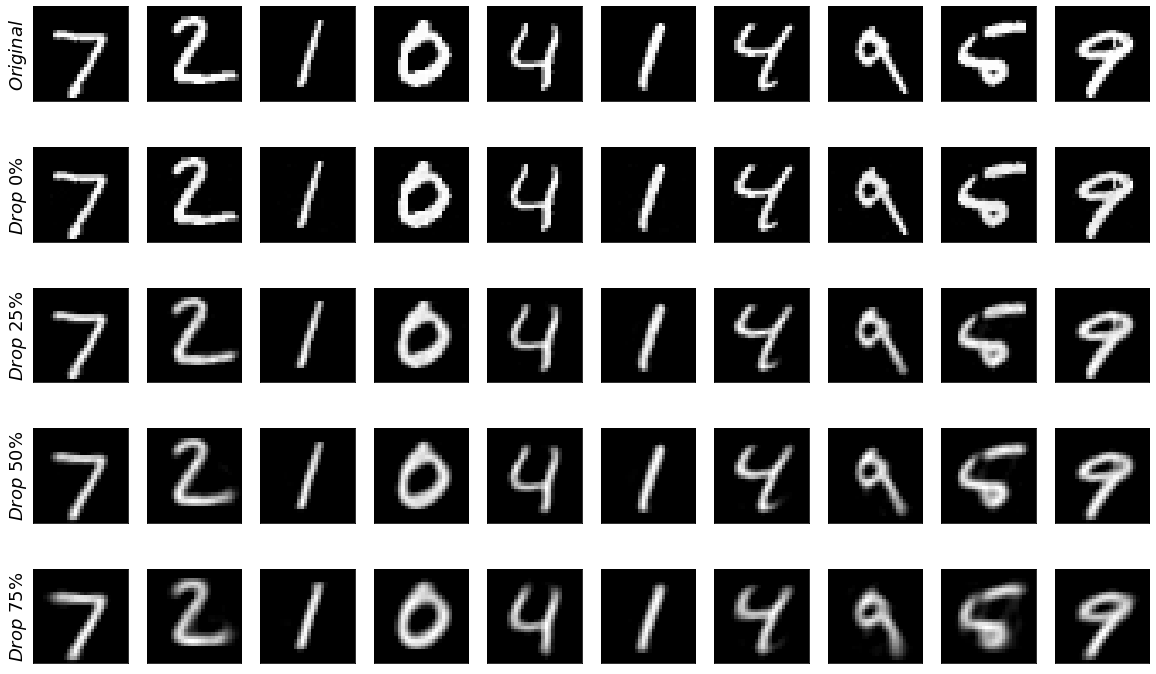

In [0]:
fig, ax = plt.subplots(ncols=10, nrows=5, figsize=(20, 2.5*5))
for i in range(10):
  im=x_test[i]
  ax[0, i].imshow(im.reshape(28,28).astype('int'), cmap='gray');
  ax[0, i].get_xaxis().set_ticks([])
  ax[0, i].get_yaxis().set_ticks([])
  ax[0, 0].set_ylabel(f"$Original$",fontsize=18)
for i in range(10):
  ax[1, i].imshow(REC1[0][i].reshape(28,28).astype('int'),cmap='gray')
  ax[1, i].get_xaxis().set_ticks([])
  ax[1, i].get_yaxis().set_ticks([])
  ax[1, 0].set_ylabel(f"$Drop$ 0%",fontsize=18)
  ax[2, i].imshow(REC1[1][i].reshape(28,28).astype('int'),cmap='gray')
  ax[2, i].get_xaxis().set_ticks([])
  ax[2, i].get_yaxis().set_ticks([])
  ax[2, 0].set_ylabel(f"$Drop$ 25%",fontsize=18)
  ax[3, i].imshow(REC1[2][i].reshape(28,28).astype('int'),cmap='gray')
  ax[3, i].get_xaxis().set_ticks([])
  ax[3, i].get_yaxis().set_ticks([])
  ax[3, 0].set_ylabel(f"$Drop$ 50%",fontsize=18)
  ax[4, i].imshow(REC1[3][i].reshape(28,28).astype('int'),cmap='gray')
  ax[4, i].get_xaxis().set_ticks([])
  ax[4, i].get_yaxis().set_ticks([])
  ax[4, 0].set_ylabel(f"$Drop$ 75%",fontsize=18)

In [0]:
MSE1

[4.784266754150391, 136.01086466979982, 328.4368291511536, 738.4314643554687]

### 1.2 MLP-2

In [0]:
MSE2=[]
REC2=[]

0% of dropout

In [0]:
train_loader = torch.utils.data.DataLoader(x_train, batch_size=500,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(x_test, batch_size=500,
                                         shuffle=False, num_workers=2)
encoder = lambda hid: nn.Sequential(
                        torch.nn.Linear(784,2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        
                       

                        torch.nn.Linear(2048, hid,bias=True),
                        ) 

decoder =  lambda hid: nn.Sequential( 
                        torch.nn.Linear(hid, 2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        
                       

                        torch.nn.Linear(2048, 784, bias=True),
                        torch.nn.BatchNorm1d(784),
                        torch.nn.ReLU(),
                        ) 

In [0]:
device = 'cuda:0'

net = AE(encoder(1000), decoder(1000))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

epochs = 1000
train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

Epoch 50/1000 || Loss:  Train 6177.8857 | Validation 5894.5400
Epoch 100/1000 || Loss:  Train 5409.5723 | Validation 5110.3936
Epoch 150/1000 || Loss:  Train 4619.4194 | Validation 4406.4741
Epoch 200/1000 || Loss:  Train 3927.2305 | Validation 3766.3032
Epoch 250/1000 || Loss:  Train 3428.6934 | Validation 3173.9819
Epoch 300/1000 || Loss:  Train 2837.9917 | Validation 2660.2542
Epoch 350/1000 || Loss:  Train 2353.7957 | Validation 2212.6050
Epoch 400/1000 || Loss:  Train 1942.5243 | Validation 1783.8951
Epoch 450/1000 || Loss:  Train 1574.4459 | Validation 1449.8148
Epoch 500/1000 || Loss:  Train 1148.8241 | Validation 1130.4365
Epoch 550/1000 || Loss:  Train 919.6266 | Validation 868.6699
Epoch 600/1000 || Loss:  Train 695.5673 | Validation 649.2319
Epoch 650/1000 || Loss:  Train 488.2134 | Validation 452.1800
Epoch 700/1000 || Loss:  Train 339.5865 | Validation 309.6317
Epoch 750/1000 || Loss:  Train 222.7429 | Validation 197.1481
Epoch 800/1000 || Loss:  Train 128.6500 | Validatio

In [0]:
net.eval()
test_loader = torch.utils.data.DataLoader(x_test, batch_size=1,
                                         shuffle=False, num_workers=2)
batch_count=0
reconstruction_time=[]
running_loss_val=0
for X in test_loader:
    X=X.to(device)
    encoded=net.encoder(X)
    start=time.time()
    reconstructions_batch=net.decoder(encoded)
    end=time.time()
    reconstruction_time.append(end-start)
    if batch_count == 0:
      rec = reconstructions_batch
    else:
      rec = torch.cat((rec, reconstructions_batch), dim=0)
    batch_count += 1
    loss_val = criterion(reconstructions_batch, X)
    running_loss_val += loss_val.item()
MSE2.append(running_loss_val/batch_count)
rec = rec.cpu().detach().numpy()
REC2.append(rec)
mean=np.mean(np.array(reconstruction_time))
print("decode one sample in "+str(mean)+'s')

decode one sample in 0.0003001735210418701s


25% of dropout

In [0]:
train_loader = torch.utils.data.DataLoader(x_train, batch_size=500,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(x_test, batch_size=500,
                                         shuffle=False, num_workers=2)
encoder = lambda hid: nn.Sequential(
                        torch.nn.Linear(784,2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                       

                        torch.nn.Linear(2048, hid,bias=True),
                        ) 

decoder =  lambda hid: nn.Sequential( 
                        torch.nn.Linear(hid, 2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                       

                        torch.nn.Linear(2048, 784, bias=True),
                        torch.nn.BatchNorm1d(784),
                        torch.nn.ReLU(),
                        ) 

In [0]:
device = 'cuda:0'

net = AE(encoder(1000), decoder(1000))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

epochs = 1000
train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

Epoch 50/1000 || Loss:  Train 6216.3872 | Validation 5930.9556
Epoch 100/1000 || Loss:  Train 5588.8423 | Validation 5163.7007
Epoch 150/1000 || Loss:  Train 4827.2051 | Validation 4468.5879
Epoch 200/1000 || Loss:  Train 3902.5168 | Validation 3832.9944
Epoch 250/1000 || Loss:  Train 3516.1338 | Validation 3279.8997
Epoch 300/1000 || Loss:  Train 2875.3411 | Validation 2759.9944
Epoch 350/1000 || Loss:  Train 2363.9844 | Validation 2294.7454
Epoch 400/1000 || Loss:  Train 2070.1721 | Validation 1888.8644
Epoch 450/1000 || Loss:  Train 1676.4277 | Validation 1526.7158
Epoch 500/1000 || Loss:  Train 1369.1082 | Validation 1233.9263
Epoch 550/1000 || Loss:  Train 1153.5382 | Validation 949.9514
Epoch 600/1000 || Loss:  Train 858.6636 | Validation 720.3552
Epoch 650/1000 || Loss:  Train 647.0336 | Validation 547.9894
Epoch 700/1000 || Loss:  Train 497.5662 | Validation 398.0347
Epoch 750/1000 || Loss:  Train 393.9688 | Validation 275.9344
Epoch 800/1000 || Loss:  Train 322.5378 | Validati

In [0]:
net.eval()
test_loader = torch.utils.data.DataLoader(x_test, batch_size=1,
                                         shuffle=False, num_workers=2)
batch_count=0
reconstruction_time=[]
running_loss_val=0
for X in test_loader:
    X=X.to(device)
    encoded=net.encoder(X)
    start=time.time()
    reconstructions_batch=net.decoder(encoded)
    end=time.time()
    reconstruction_time.append(end-start)
    if batch_count == 0:
      rec = reconstructions_batch
    else:
      rec = torch.cat((rec, reconstructions_batch), dim=0)
    batch_count += 1
    loss_val = criterion(reconstructions_batch, X)
    running_loss_val += loss_val.item()
MSE2.append(running_loss_val/batch_count)
rec = rec.cpu().detach().numpy()
REC2.append(rec)
mean=np.mean(np.array(reconstruction_time))
print("decode one sample in "+str(mean)+'s')

decode one sample in 0.00029851627349853515s


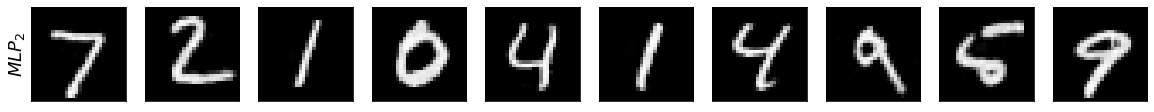

In [0]:
fig, ax = plt.subplots(ncols=10, nrows=1, figsize=(20, 2.5))
for X_test in test_loader:
  for i in range(10):
      ax[i].imshow(rec[i].reshape(28,28),cmap='gray')
      ax[i].get_xaxis().set_ticks([])
      ax[i].get_yaxis().set_ticks([])
  ax[0].set_ylabel(f"$MLP_2$",fontsize=18)
  break

50% of dropout

In [0]:
train_loader = torch.utils.data.DataLoader(x_train, batch_size=500,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(x_test, batch_size=500,
                                         shuffle=False, num_workers=2)
encoder = lambda hid: nn.Sequential(
                        torch.nn.Linear(784,2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.50),
                       

                        torch.nn.Linear(2048, hid,bias=True),
                        ) 

decoder =  lambda hid: nn.Sequential( 
                        torch.nn.Linear(hid, 2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.50),
                       

                        torch.nn.Linear(2048, 784, bias=True),
                        torch.nn.BatchNorm1d(784),
                        torch.nn.ReLU(),
                        ) 

In [0]:
device = 'cuda:0'

net = AE(encoder(1000), decoder(1000))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

epochs = 1000
train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

Epoch 50/1000 || Loss:  Train 6468.7944 | Validation 5953.5156
Epoch 100/1000 || Loss:  Train 5589.8389 | Validation 5219.7163
Epoch 150/1000 || Loss:  Train 4944.9238 | Validation 4538.9097
Epoch 200/1000 || Loss:  Train 4117.8208 | Validation 3920.5500
Epoch 250/1000 || Loss:  Train 3516.3062 | Validation 3357.6260
Epoch 300/1000 || Loss:  Train 3000.5857 | Validation 2853.3281
Epoch 350/1000 || Loss:  Train 2670.4346 | Validation 2432.0913
Epoch 400/1000 || Loss:  Train 2219.0056 | Validation 2020.4373
Epoch 450/1000 || Loss:  Train 1852.3557 | Validation 1674.2988
Epoch 500/1000 || Loss:  Train 1535.0461 | Validation 1380.6783
Epoch 550/1000 || Loss:  Train 1263.1340 | Validation 1093.3706
Epoch 600/1000 || Loss:  Train 1047.8812 | Validation 867.7397
Epoch 650/1000 || Loss:  Train 884.8054 | Validation 679.5134
Epoch 700/1000 || Loss:  Train 739.6360 | Validation 522.5627
Epoch 750/1000 || Loss:  Train 589.1882 | Validation 401.9738
Epoch 800/1000 || Loss:  Train 537.4294 | Valida

In [0]:
net.eval()
test_loader = torch.utils.data.DataLoader(x_test, batch_size=1,
                                         shuffle=False, num_workers=2)
batch_count=0
reconstruction_time=[]
running_loss_val=0
for X in test_loader:
    X=X.to(device)
    encoded=net.encoder(X)
    start=time.time()
    reconstructions_batch=net.decoder(encoded)
    end=time.time()
    reconstruction_time.append(end-start)
    if batch_count == 0:
      rec = reconstructions_batch
    else:
      rec = torch.cat((rec, reconstructions_batch), dim=0)
    batch_count += 1
    loss_val = criterion(reconstructions_batch, X)
    running_loss_val += loss_val.item()
MSE2.append(running_loss_val/batch_count)
rec = rec.cpu().detach().numpy()
REC2.append(rec)
mean=np.mean(np.array(reconstruction_time))
print("decode one sample in "+str(mean)+'s')

decode one sample in 0.00030584311485290527s


75% of dropout

In [0]:
train_loader = torch.utils.data.DataLoader(x_train, batch_size=500,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(x_test, batch_size=500,
                                         shuffle=False, num_workers=2)
encoder = lambda hid: nn.Sequential(
                        torch.nn.Linear(784,2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.75),
                       

                        torch.nn.Linear(2048, hid,bias=True),
                        ) 

decoder =  lambda hid: nn.Sequential( 
                        torch.nn.Linear(hid, 2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.75),
                       

                        torch.nn.Linear(2048, 784, bias=True),
                        torch.nn.BatchNorm1d(784),
                        torch.nn.ReLU(),
                        ) 

In [0]:
device = 'cuda:0'

net = AE(encoder(1000), decoder(1000))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

epochs = 1000
train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

Epoch 50/1000 || Loss:  Train 6340.1436 | Validation 5998.1992
Epoch 100/1000 || Loss:  Train 5645.4736 | Validation 5302.7993
Epoch 150/1000 || Loss:  Train 4798.9858 | Validation 4648.6099
Epoch 200/1000 || Loss:  Train 4287.3594 | Validation 4069.9121
Epoch 250/1000 || Loss:  Train 3677.8650 | Validation 3558.7654
Epoch 300/1000 || Loss:  Train 3244.3315 | Validation 3052.8208
Epoch 350/1000 || Loss:  Train 2833.0627 | Validation 2627.4958
Epoch 400/1000 || Loss:  Train 2442.5889 | Validation 2245.6021
Epoch 450/1000 || Loss:  Train 2107.9817 | Validation 1938.8804
Epoch 500/1000 || Loss:  Train 1849.4282 | Validation 1606.9935
Epoch 550/1000 || Loss:  Train 1640.6909 | Validation 1360.3652
Epoch 600/1000 || Loss:  Train 1425.3435 | Validation 1134.1720
Epoch 650/1000 || Loss:  Train 1243.0498 | Validation 944.8298
Epoch 700/1000 || Loss:  Train 1134.8081 | Validation 802.2310
Epoch 750/1000 || Loss:  Train 1033.6666 | Validation 673.6844
Epoch 800/1000 || Loss:  Train 990.2592 | Va

In [0]:
net.eval()
test_loader = torch.utils.data.DataLoader(x_test, batch_size=1,
                                         shuffle=False, num_workers=2)
batch_count=0
reconstruction_time=[]
running_loss_val=0
for X in test_loader:
    X=X.to(device)
    encoded=net.encoder(X)
    start=time.time()
    reconstructions_batch=net.decoder(encoded)
    end=time.time()
    reconstruction_time.append(end-start)
    if batch_count == 0:
      rec = reconstructions_batch
    else:
      rec = torch.cat((rec, reconstructions_batch), dim=0)
    batch_count += 1
    loss_val = criterion(reconstructions_batch, X)
    running_loss_val += loss_val.item()
MSE2.append(running_loss_val/batch_count)
rec = rec.cpu().detach().numpy()
REC2.append(rec)
mean=np.mean(np.array(reconstruction_time))
print("decode one sample in "+str(mean)+'s')

decode one sample in 0.0003097679615020752s


In [0]:
MSE2

[3.870105979681015, 56.487842401981354, 174.67230813217162, 440.67051216125486]

Collecting results in one fig for MLP-2

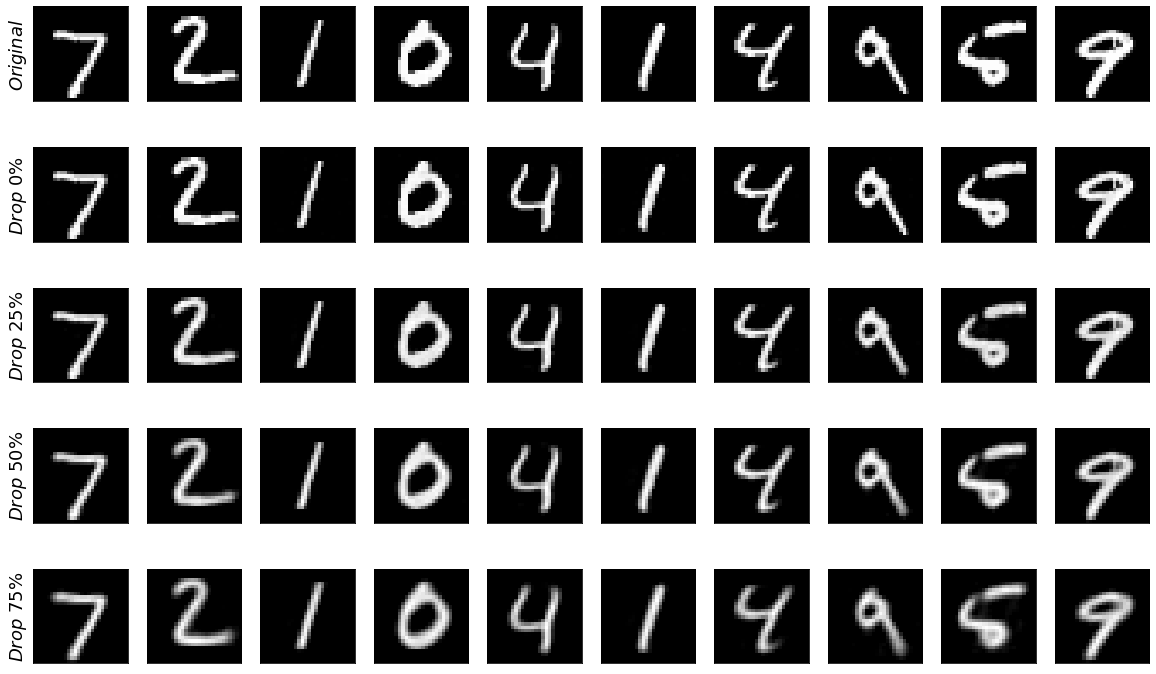

In [0]:
fig, ax = plt.subplots(ncols=10, nrows=5, figsize=(20, 2.5*5))
for i in range(10):
  im=x_test[i]
  ax[0, i].imshow(im.reshape(28,28).astype('int'),cmap='gray');
  ax[0, i].get_xaxis().set_ticks([])
  ax[0, i].get_yaxis().set_ticks([])
  ax[0, 0].set_ylabel(f"$Original$",fontsize=18)
for i in range(10):
  ax[1, i].imshow(REC2[0][i].reshape(28,28).astype('int'),cmap='gray')
  ax[1, i].get_xaxis().set_ticks([])
  ax[1, i].get_yaxis().set_ticks([])
  ax[1, 0].set_ylabel(f"$Drop$ 0%",fontsize=18)
  ax[2, i].imshow(REC2[1][i].reshape(28,28).astype('int'),cmap='gray')
  ax[2, i].get_xaxis().set_ticks([])
  ax[2, i].get_yaxis().set_ticks([])
  ax[2, 0].set_ylabel(f"$Drop$ 25%",fontsize=18)
  ax[3, i].imshow(REC2[2][i].reshape(28,28).astype('int'),cmap='gray')
  ax[3, i].get_xaxis().set_ticks([])
  ax[3, i].get_yaxis().set_ticks([])
  ax[3, 0].set_ylabel(f"$Drop$ 50%",fontsize=18)
  ax[4, i].imshow(REC2[3][i].reshape(28,28).astype('int'),cmap='gray')
  ax[4, i].get_xaxis().set_ticks([])
  ax[4, i].get_yaxis().set_ticks([])
  ax[4, 0].set_ylabel(f"$Drop$ 75%",fontsize=18)

## 2. MLP-2 train mnist/test omniglot

In [0]:

(x_train, y_train), _ = mnist.load_data()

In [0]:
import torchvision

dataset = torchvision.datasets.Omniglot(
    root="./data", download=True, transform=torchvision.transforms.ToTensor()
)
label=[]

for i in range(0,len(dataset)):
  if i==0:
    image, _ = dataset[i]
    label.append(dataset[i][1])
    
  elif dataset[i][1]!=label[-1]:
    image=torch.cat((image, dataset[i][0]), dim=0)
    label.append(dataset[i][1])

label0=[]
for i in range(0, 1000):
  if i==0:
    image=torch.cat((image, dataset[i+1][0]), dim=0)
    label0.append(dataset[i+1][1])
  elif dataset[i+1][1]!=label0[-1]:
    image=torch.cat((image, dataset[i+1][0]), dim=0)
    label0.append(dataset[i+1][1])
  if len(label0)>=1000-len(label):
    break

Files already downloaded and verified


In [0]:
x_test=image.numpy()
label=np.array(label)
label0=np.array(label0)
y_test=np.concatenate((label, label0),axis=None)

In [0]:
import cv2
x_test_res=[]
for i in range(0,len(x_test)):
  x_test[i] = cv2.subtract(1, x_test[i]) 
  x_test_res.append(cv2.resize(x_test[i], (28,28)))
x_test_res=np.array(x_test_res)

In [0]:
x_test_res=(x_test_res*255).astype('int')

In [0]:
x_test_res.shape

(1000, 28, 28)

In [0]:
img_rows, img_cols = 28,28
x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
x_test = x_test_res.reshape(x_test_res.shape[0], img_rows*img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print("[mnist] x_train.shape={}, y_train.shape={}".format(x_train.shape, y_train.shape))
print("[omniglot] x_test.shape={}, y_test.shape={}".format(x_test.shape, y_test.shape))

train_loader = torch.utils.data.DataLoader(x_train, batch_size=500,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(x_test, batch_size=500,
                                         shuffle=False, num_workers=2)

[mnist] x_train.shape=(60000, 784), y_train.shape=(60000,)
[omniglot] x_test.shape=(1000, 784), y_test.shape=(1000,)


In [0]:

encoder = lambda hid: nn.Sequential(
                        torch.nn.Linear(784,2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                       

                        torch.nn.Linear(2048, hid,bias=True),
                        ) 

decoder =  lambda hid: nn.Sequential( 
                        torch.nn.Linear(hid, 2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                       

                        torch.nn.Linear(2048, 784, bias=True),
                        torch.nn.BatchNorm1d(784),
                        torch.nn.ReLU(),
                        ) 


In [0]:
device = 'cuda:0'

net = AE(encoder(1000), decoder(1000))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [0]:
epochs = 1000
train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

Epoch 50/1000 || Loss:  Train 6469.3145 | Validation 3938.2532
Epoch 100/1000 || Loss:  Train 5545.1328 | Validation 3499.3645
Epoch 150/1000 || Loss:  Train 4751.9805 | Validation 3110.2646
Epoch 200/1000 || Loss:  Train 4181.3159 | Validation 2755.4858
Epoch 250/1000 || Loss:  Train 3497.1729 | Validation 2432.9375
Epoch 300/1000 || Loss:  Train 2895.6318 | Validation 2138.9124
Epoch 350/1000 || Loss:  Train 2505.7219 | Validation 1881.6561
Epoch 400/1000 || Loss:  Train 2082.4634 | Validation 1652.8691
Epoch 450/1000 || Loss:  Train 1735.4149 | Validation 1436.1825
Epoch 500/1000 || Loss:  Train 1326.1376 | Validation 1241.2253
Epoch 550/1000 || Loss:  Train 1099.5643 | Validation 1091.2189
Epoch 600/1000 || Loss:  Train 865.6191 | Validation 944.4141
Epoch 650/1000 || Loss:  Train 683.4636 | Validation 819.5081
Epoch 700/1000 || Loss:  Train 509.4212 | Validation 715.0513
Epoch 750/1000 || Loss:  Train 431.1714 | Validation 626.0457
Epoch 800/1000 || Loss:  Train 324.0486 | Validat

Text(0, 0.5, '$MLP_2$')

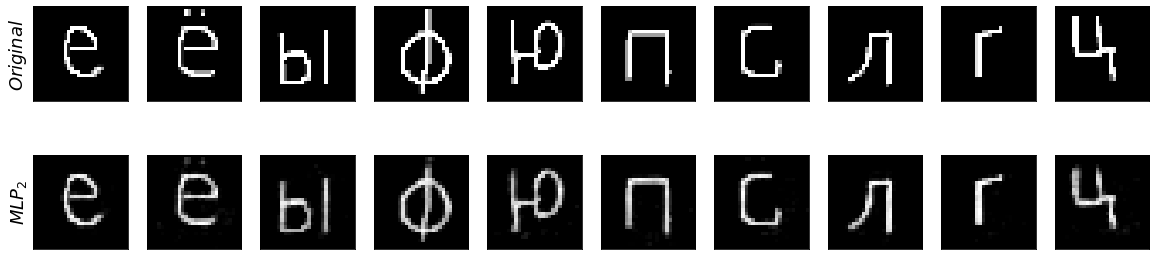

In [0]:
from google.colab import files
net.eval()
batch_count=0
reconstruction_time=[]
running_loss_val = 0.0
i = 0
for X in test_loader:
    X=X.to(device)
    encoded_imgs = net.encoder(X)
    start=time.time()
    decoded_imgs = net.decoder(encoded_imgs)
    end=time.time()
    reconstruction_time.append(end-start)
    if batch_count == 0:
      rec = decoded_imgs
    else:
      rec = torch.cat((rec, decoded_imgs), dim=0)
    batch_count += 1
    loss_val = criterion(decoded_imgs, X)
    running_loss_val += loss_val.item()

rec = rec.cpu().detach().numpy()
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))
for i in range(10):
  ax[0,i].imshow(x_test[i].reshape(28,28).astype('int'), cmap='gray')
  ax[0,i].get_xaxis().set_ticks([])
  ax[0,i].get_yaxis().set_ticks([])
  ax[1,i].imshow(rec[i].reshape(28,28).astype('int'),cmap='gray')
  ax[1,i].get_xaxis().set_ticks([])
  ax[1,i].get_yaxis().set_ticks([])
ax[0,0].set_ylabel(f"$Original$",fontsize=18)
ax[1,0].set_ylabel(f"$MLP_2$",fontsize=18)

In [0]:
mean=np.mean(np.array(reconstruction_time))
print(f'MSE: {running_loss_val/batch_count}')
print("decode one sample in "+str(mean)+'s')

MSE: 461.7225036621094
decode one sample in 0.0003612041473388672s
